# Airbnb Survey Dataset Analysis Notebook

### Notebook by [Anand Niranjan](http://niranand.paperplane.io/)

## Table of contents
1. [Introduction](#Introduction)
2. [Cleaning Data](#Cleaning Data)
3. [Data Exploration](#Data Exploration)
4. [K-means Algorithm](#K-means Algorithm)
5. [Decision Tree Classifier](#Decision Tree Classifier)
6. [Decision Tree Parameter Tuning](#Decision Tree Parameter Tuning)
7. [Random Forest Classifier](#Random Forest Classifier)
8. [Conclusion](#Conclusion)

## Introduction
The datasets of Airbnb survey data is analysed to build a data analysis pipeline for developing a predective model by trying different classifier models and comparing their performance. Initially, the data is cleaned by analysing the basic information and making charts to identify any outliers and get an idea about the data patterns in the dataset.

Loading required libraries and importing the datasets

In [1]:
import os
import glob
import math
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt

from IPython.display import display
from IPython.core.display import display, HTML

from sklearn.cluster import KMeans
from sklearn.tree import DecisionTreeClassifier, export_graphviz

%matplotlib inline

# Loading csv files
path = os.getcwd()
all_files = glob.glob(os.path.join(path, "airbnb_survey/*2016*.csv"))
# all_files = glob.glob(os.path.join(path, "airbnb_survey/*.csv"))

# Concat all csv and include city names as column
df_each_file = (pd.read_csv(f).assign(city=os.path.basename(f).split('_')[2]) for f in all_files)
data = pd.concat(df_each_file, ignore_index=True)

## Cleaning Data

data.info() and data.head() gives an idea about the columns that don't have much importance in the analysis and can be dropped from the dataframe. Data types are matched with the data and converted accordingly. Some rows with incomplete data are either dropped completely or the missing fields are filled with values by analyzing the entire population.

In [2]:
# DATA CLEANING
# Initial analysis of data by dataframe.info() & dataframe.describe()

# Convert string date time to timestamp dtype
data.last_modified = data.last_modified.astype('datetime64[ns]')

# Dropping columns with all null values and unwanted columns
reject_cols = ['country', 'borough', 'minstay', 'bathrooms','location','name','room_id','survey_id','latitude','longitude']

for col in reject_cols:
    try:
        data.drop(col, axis=1, inplace=True)
    except ValueError:
        pass

#The property_value col is null for nearly 99% of records, so dropping it
try:
    data.drop(['property_type'], axis=1, inplace=True)
except ValueError:
    pass

#Droping rows as price is null and total null records is less than 1% of population size
if len(data[data.price.isnull()]) < len(data)*0.01:
    data.dropna(subset=['price'], inplace=True)

#Drop rows with null room_type as they won't be used in our analysis
#In this case there are only 2 rows 
data.dropna(subset=['room_type'], inplace=True)

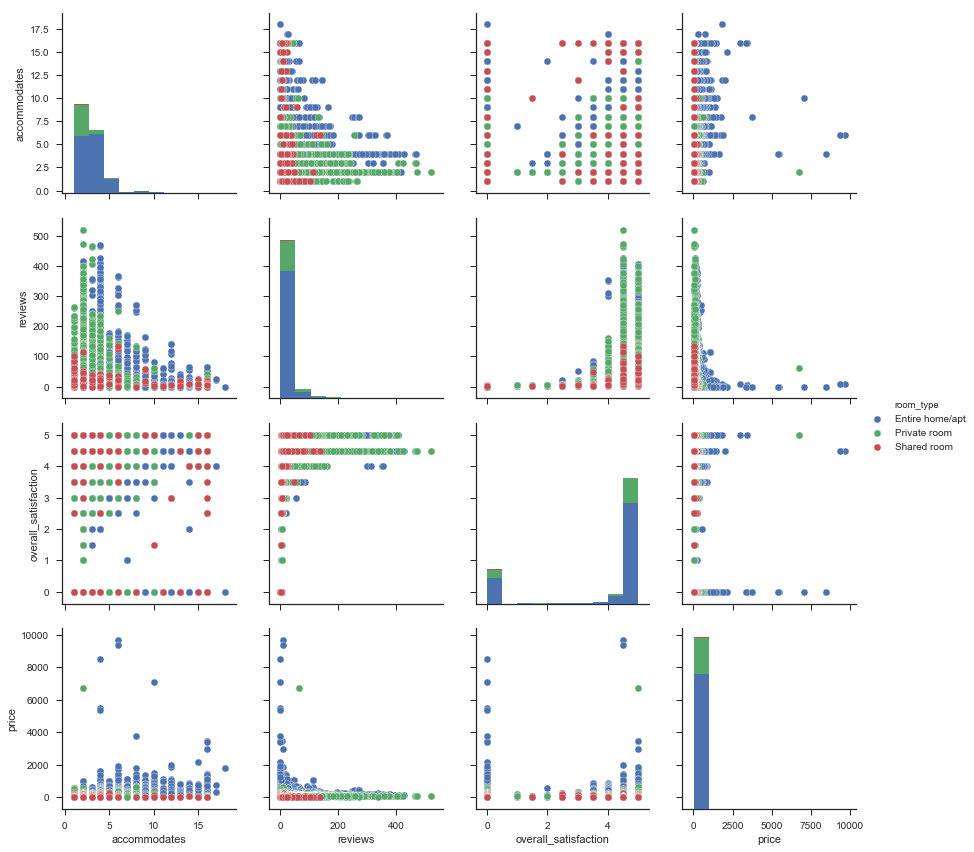

In [3]:
# Matrix plot to check how the data looks and find any outliers
display(HTML('<h4>Visualize data in pairplot</h4>'))
sb.set(style="ticks", color_codes=True)
sb.pairplot(data.dropna(), hue='room_type', size=3, kind='scatter',
            vars=['accommodates','reviews','overall_satisfaction','price'])
# data.loc[data['room_type'] == 'Private room', ['price']].hist()

From Scatterplot Matrix, we see that there are no data points above price 10000, however descriptive stats shows that max of price is around 17000. It can also be verified by plotting a line graph of price. There are only 9 records more than 10000 and have additinal missing values, so we will drop them as they seem to be outliers.

9


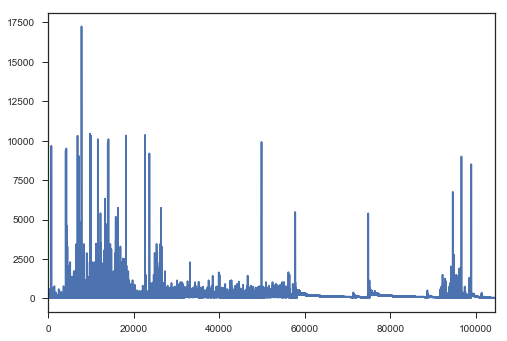

In [4]:
data.price.plot.line()
print(len(data[data.price > 10000])) # 9

In [5]:
data.drop(data[data.price > 10000].index, inplace=True)
len(data[data.price > 10000])

0

#### Missing Data Imputation

2    47744
4    29706
3     9185
6     6414
5     4094
Name: accommodates, dtype: int64


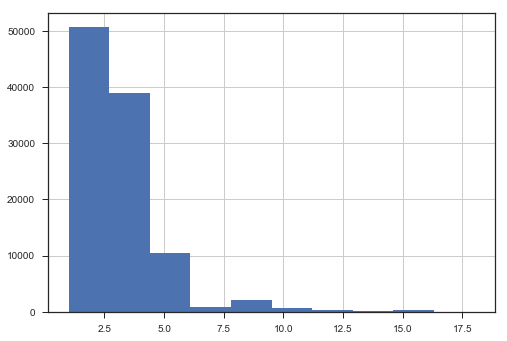

In [9]:
#Now we see that accommodates field has few null records
missing_records = len(data[data.accommodates.isnull()]) # 1317 out of 495278 records
display(HTML('<h4>Top 5 Frequency of Accommodates:</h4>'))
print(data.accommodates.value_counts()[:5])

display(HTML('<h4>Histogram of Accommodates Frequency</h4>'))
data['accommodates'].hist(bins=10)

Accommodated is the # of person allowed in a room or apartment. Most of the Accommodated value falls within the range 2 and 7, so the missing values are replaced with average measure of this range.

In [10]:
mean_accommodate = math.ceil(data.accommodates.mean())
data.loc[(data['accommodates'].isnull()), 'accommodates'] = mean_accommodate

Missing data imputation for overall_satisfaction column.

overall_satisfaction value of '0' is most frequent, however 5.0 and 4.5 also are a larger part of population.
By plotting it against and reviews and taking median, gives us an idea that 4.5 can be apt value to replace the nulls

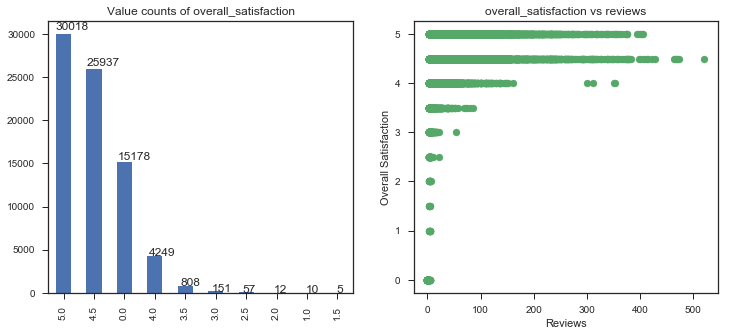

In [11]:
# Missing data imputation for overall_satisfaction column
# Plot of value counts of each satisfaction value

# display(HTML('<h4>Median of overall_satisfaction:</h4>'))
median_ov_satis = data.overall_satisfaction.median()
# print(median_ov_satis)

def os_counts_plot(ax=None):
    axis=data.overall_satisfaction.value_counts().plot('bar', title="Value counts of overall_satisfaction")
    for p in ax.patches:
        axis.annotate(int(p.get_height()), (p.get_x() * 1.025, p.get_height() * 1.015))

def os_reviews_plot(ax=None):
    plt.scatter( data.reviews, data.overall_satisfaction, c='g')
    plt.xlabel("Reviews")
    plt.ylabel("Overall Satisfaction")
    plt.title("overall_satisfaction vs reviews")


fig = plt.figure(figsize = (12,5))
ax1 = fig.add_subplot(1,2,1)
os_counts_plot(ax1)
ax2 = fig.add_subplot(1,2,2)
os_reviews_plot(ax2)

# Imputing null values
data['overall_satisfaction'].fillna(median_ov_satis, inplace=True)

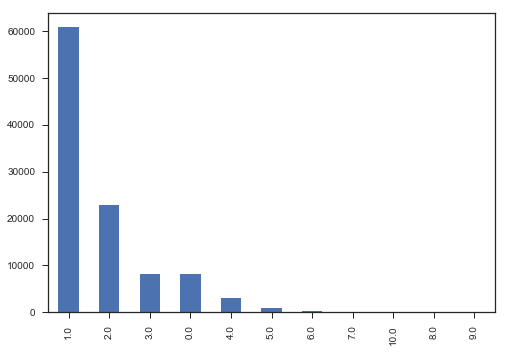

In [12]:
# Similarly, for bedrooms also
data.bedrooms.value_counts().plot('bar')
bed_plot = data.loc[(data['bedrooms'].isnull()), 'bedrooms'] = data.bedrooms.median()

In [17]:
# Reset the indexes as we have dropped some rows
data.reset_index(drop=True, inplace=True)
print(data.info())
print(data.describe())
data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104393 entries, 0 to 104392
Data columns (total 10 columns):
host_id                 104393 non-null int64
room_type               104393 non-null object
neighborhood            104393 non-null object
reviews                 104393 non-null int64
overall_satisfaction    104393 non-null float64
accommodates            104393 non-null int64
bedrooms                104393 non-null float64
price                   104393 non-null float64
last_modified           104393 non-null datetime64[ns]
city                    104393 non-null object
dtypes: datetime64[ns](1), float64(3), int64(3), object(3)
memory usage: 8.0+ MB
None
            host_id        reviews  overall_satisfaction   accommodates  \
count  1.043930e+05  104393.000000         104393.000000  104393.000000   
mean   2.927301e+07      13.096711              3.957387       3.285920   
std    2.650458e+07      27.453860              1.657518       1.806931   
min    2.510000e+02      

,host_id,room_type,neighborhood,reviews,overall_satisfaction,accommodates,bedrooms,price,last_modified,city
0,41542517,Entire home/apt,24,0,4.5,2,1.0,68.0,2016-10-29 01:40:46.027981,aarhus
1,97637165,Entire home/apt,24,1,4.5,2,0.0,61.0,2016-10-29 01:40:43.172380,aarhus
2,36273927,Entire home/apt,24,1,4.5,4,1.0,68.0,2016-10-29 01:40:29.574765,aarhus
3,11206742,Entire home/apt,24,5,5.0,4,2.0,87.0,2016-10-29 01:40:22.214220,aarhus
4,6193751,Private room,24,1,4.5,2,1.0,61.0,2016-10-29 01:40:13.690172,aarhus


## Data Exploration
Now, data is cleansed and missing values are filled. Take a look into descriptive statistics to understand data.

                   reviews                      overall_satisfaction       \
                      mean amin amax        std                 mean amin   
room_type                                                                   
Entire home/apt  11.630153    0  469  23.743593             3.997877  0.0   
Private room     19.076594    0  520  38.488614             3.806401  0.0   
Shared room       8.609831    0  136  15.386552             3.629800  0.0   

                               accommodates                           price  \
                amax       std         mean amin amax       std        mean   
room_type                                                                     
Entire home/apt  5.0  1.621424     3.576775    1   18  1.834686  160.230034   
Private room     5.0  1.780913     2.127353    1   16  0.942884   75.858240   
Shared room      5.0  1.792841     3.299539    1   16  3.564049   56.456221   

                                           bedrooms           

     host_id        room_type            neighborhood  reviews  \
0  6999042.0  Entire home/apt  De Baarsjes / Oud West      0.0   

   overall_satisfaction  accommodates  bedrooms  price  \
0                   4.5           2.0       1.0   80.0   

               last_modified       city  
0 2016-05-13 00:24:05.553308  amsterdam  


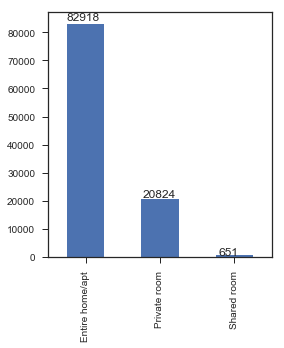

In [18]:
# Now the data is cleaned and missing fields has been filled.
# Grouping the data by room_types and calculate its descriptive stats
def room_type_stats(data):
    room_type_gp = data.groupby(['room_type'])
    room_type_stat = room_type_gp['reviews','overall_satisfaction','accommodates','price','bedrooms']
    room_type_stat = room_type_stat.agg([np.mean, np.min, np.max, np.std])
    display(HTML('<h4>Stats of various types of rooms:</h4>'))
    print(room_type_stat)
    
room_type_stats(data)

# Most common in fields
display(HTML('<h4>Common Field Element:</h4>'))
print(data.mode()[:1])

# Bar plot to see how many rooms of various types booked
plt.figure(figsize=(4,4.5))
display(HTML('<h4>Room Types Bar Plot</h4>'))
ax = data['room_type'].value_counts().plot(kind='bar')
for p in ax.patches:
    ax.annotate(int(p.get_height()), (p.get_x() * 1.025, p.get_height() * 1.015))

#### Analysing aggregate prices in every city for each room type:

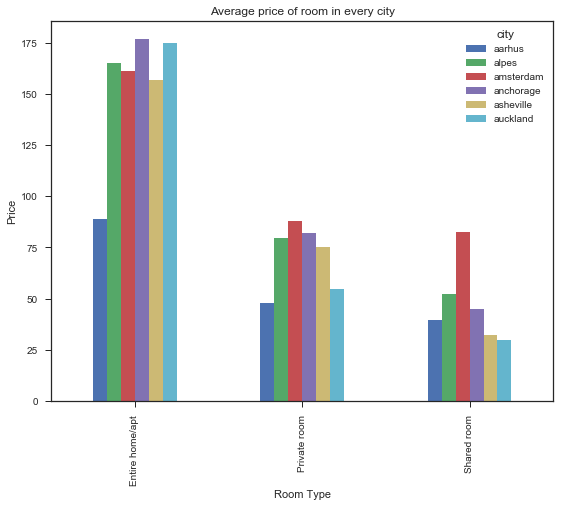

In [19]:
# What are the prices in every city for different rooms
# Price of room_type Entire home/apt is high in Anchorage city whereas Private & shared room are high in Amsterdam
city_gp = data.groupby(['room_type','city'])
city_gp = city_gp['price'].mean()

# print(city_gp.unstack())
city_names=list(city_gp.unstack().columns)
city_plot = city_gp.unstack().plot(kind='bar',stacked=False,figsize=(9, 7),title="Average price of room in every city")
city_plot.set_xlabel("Room Type")
city_plot.set_ylabel("Price")
# city_plot.legend(city_names, loc=1,ncol=1)


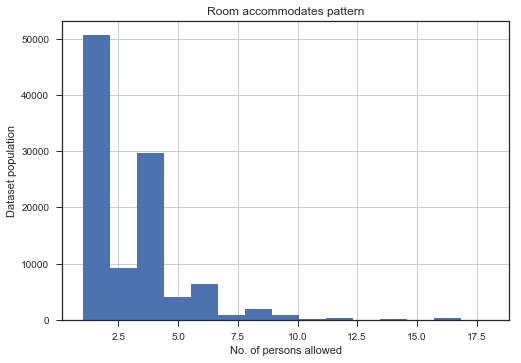

In [20]:
# Distribution of accommodates data field
# We can see that most of the rooms allow accommodation upto 6 members

accom_plot = data['accommodates'].hist(bins=15)
accom_plot.set_title("Room accommodates pattern")
accom_plot.set_xlabel("No. of persons allowed")
accom_plot.set_ylabel("Dataset population")

Now, we analyze price pattern in data with number of reviews. Both the quantities are of different measures so they will be normalized to be in range 0 and 1.

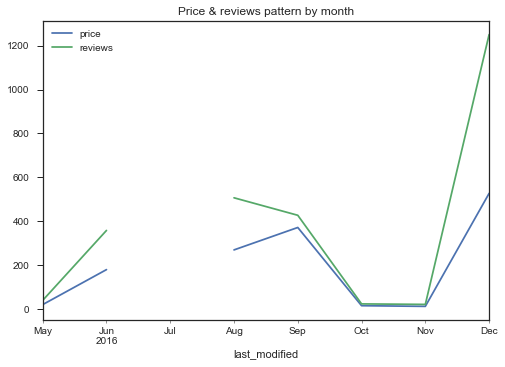

In [21]:
#As the values are not normalized for price & reviews, so the comparison will not be relevant
#Normalize the values and plot it
data_norm = data.copy()

#Normalize fields
def normalize(df, columns):
    result = df.copy()
    for col in columns:
        max_val = df[col].max()
        min_val = df[col].min()
        result[col] = (df[col] - min_val) / (max_val - min_val)
    return result

data_normaliz = normalize(data_norm, ['reviews','overall_satisfaction','accommodates','price','bedrooms'])
price_rev_pattern = data_normaliz[['price','reviews', 'last_modified']]

# set last_modified as index to analyze by date
price_rev_pattern.set_index('last_modified', inplace=True)
price_rev_pattern.head()

# Resample the data along the Month boundary
# Prices start to rise from November month, so the reviews for rooms also increase during the same time
price_rev_pattern.resample('M').sum().plot(title="Price & reviews pattern by month")

##### Density plot to relate number of bedrooms with accommodates. Both are highly correlated.

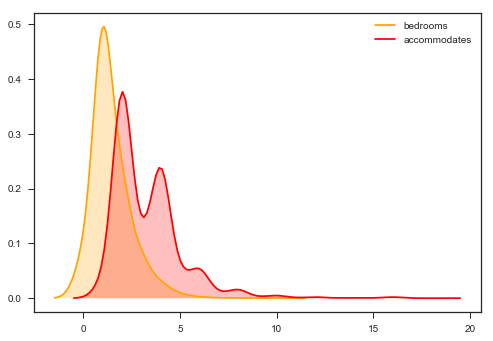

In [23]:
# Density plot to relate number of bedrooms with accommodates
sb.kdeplot(data['bedrooms'], shade=True, bw=0.5, color="orange")
sb.kdeplot(data['accommodates'], shade=True, bw=0.5, color="red")

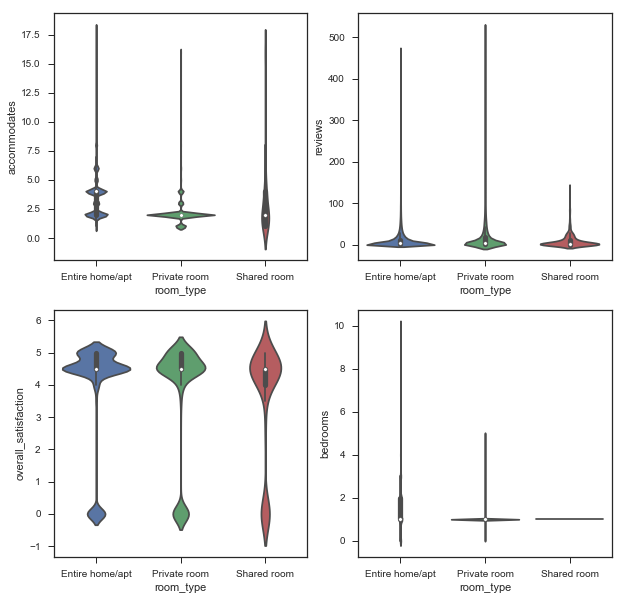

In [24]:
#Violin plot provides the depth of the population
plt.figure(figsize=(10,10))
sb.set(style="ticks", color_codes=True)
for ind,col in enumerate(['accommodates','reviews','overall_satisfaction','bedrooms','room_type']):
    if col == 'room_type':
        continue
    plt.subplot(2,2,ind+1)
    sb.violinplot(x='room_type', y=col, data=data)

## K-means Algorithm
Let's say that we need to find the property type of the room. These property type could be 'House', 'Hostel', 'Guesthouse','Bungalow' or 'Camper/RV'. Kmeans will cluster data into groups and helps to make assumptions about certain population in the data. However, in this scenario, not much information is gathered from k-means clustering.

In [25]:
#K-means clustering
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=5, max_iter=500)
data_fit = data[['reviews','overall_satisfaction','accommodates','price','bedrooms']]
kmeans.fit(data_fit)

data_df_1 = data_fit.copy()
data_df_1.insert(0, 'Clusters_a', kmeans.labels_)
# data_df_1.head(20)

cl1_gp = data_df_1.groupby(['Clusters_a'])
display(HTML('<h4>Clustered data before normalization</h4>'))
print(cl1_gp.agg([np.mean, np.min, np.max, np.std]))

#Normalize fields
def normalize(df, columns):
    result = df.copy()
    for col in columns:
        max_val = df[col].max()
        min_val = df[col].min()
        result[col] = (df[col] - min_val) / (max_val - min_val)
    return result
data_df_normalize = normalize(data_fit, ['reviews','overall_satisfaction','accommodates','price','bedrooms'])
data_df_normalize.head(20)

kmeans.fit(data_df_normalize)
data_df_2 = data_fit.copy()
data_df_2.insert(0, 'Clusters_b', kmeans.labels_)
cl2_gp = data_df_2.groupby(['Clusters_b'])

display(HTML('<h4>Clustered data after Normalization</h4>'))
print(cl2_gp.agg([np.mean, np.min, np.max, np.std]))

# data_fit_filtered = data_df_normalize[['price', 'reviews', 'overall_satisfaction']]
# kmeans = KMeans(n_clusters = 5, max_iter=500)
# kmeans.fit(data_fit_filtered)

# plt.figure(figsize=(8, 6))
# plt.scatter(data_fit_filtered, data_fit_filtered, c=kmeans.labels_.astype(float))
# plt.scatter(data_fit_filtered[:,0],data_fit_filtered[:,1], 
#             c=[matplotlib.cm.spectral(float(i) /10) for i in kmeans.labels_]);
# data_fit_filtered[:1]

              reviews                      overall_satisfaction            \
                 mean amin amax        std                 mean amin amax   
Clusters_a                                                                  
0           10.134682    0  379  20.406392             3.887296  0.0  5.0   
1            0.808081    0   21   2.614589             4.113636  0.0  5.0   
2            5.553283    0  270  13.799449             4.022105  0.0  5.0   
3            3.695652    0   63  13.182064             3.739130  0.0  5.0   
4           14.418519    0  520  29.719063             3.977783  0.0  5.0   

                     accommodates                            price          \
                 std         mean amin amax       std         mean    amin   
Clusters_a                                                                   
0           1.760301     4.203073    1   17  1.749632   218.559480   156.0   
1           1.308297    10.141414    2   18  3.778137  1895.308081  124

              reviews                      overall_satisfaction            \
                 mean amin amax        std                 mean amin amax   
Clusters_b                                                                  
0           11.259338    0  367  19.759318             4.622898  2.5  5.0   
1            9.746879    0  160  15.121576             4.435598  2.5  4.5   
2            0.688437    0    6   0.814472             0.002598  0.0  2.0   
3            6.823785    0  270  16.067388             4.581048  2.0  5.0   
4           29.919891    3  520  46.757880             4.972567  4.0  5.0   

                     accommodates                           price        \
                 std         mean amin amax       std        mean  amin   
Clusters_b                                                                
0           0.285730     4.569009    1   10  0.984886  188.815204  10.0   
1           0.210526     2.519546    1    7  0.894022  100.280873  10.0   
2       

## Decision Tree Classifier
The idea is to predict the room type with the help of different features in the dataset. The data is prepared by splitting into training and testing sets. First, a basic decision tree classifier is implemented, check its accuracy on testing set over multiple iterations, then tune the decision tree parameters and compare its performance with basic classifier.

In [38]:
#Decision Tree Classifier
#Input will be the measurement values from cleaned dataset
#scikit-learn expects each entry to be a list of value so it will be a list of lists
from sklearn.cross_validation import train_test_split

#Features on which model is trained
all_vars = data[['accommodates','bedrooms','overall_satisfaction','price','reviews']].values

#Feature to be predicted in testing set
all_rooms = data[['room_type']].values

#Splitting data into training (80%) and testing (20%) set.
#Train_test_split splits arrays into random train and test subsets. 
#Everytime, data will be shuffled so accuracy will vary for each execution of this block.

(training_inputs,
 testing_inputs,
 training_classes,
 testing_classes) = train_test_split(all_vars, all_rooms, train_size=0.80, random_state=1)

# Create a basic Decision Tree Classifier
tree = DecisionTreeClassifier()

# Train the classifier on the training set
tree.fit(training_inputs, training_classes)


try:
    #After tuning DTree parameters.Shown in "Decision Tree Parameter Tuning" step
    tree_after_tuning = tree_after_tuning # This is calculated in below steps after tuning the parameters
    tree_after_tuning.fit(training_inputs, training_classes)
except NameError:
    pass

# Validate the classifier on the testing set using classification accuracy
print("Accuracy before parameter tuning:", tree.score(testing_inputs, testing_classes))
try:
    print("Accuracy after parameter tuning:", tree_after_tuning.score(testing_inputs, testing_classes))
except NameError:
    print("NameError encountered. Tune the parameter & rerun this block")

Accuracy before parameter tuning: 0.864696585085
Accuracy after parameter tuning: 0.874562957996


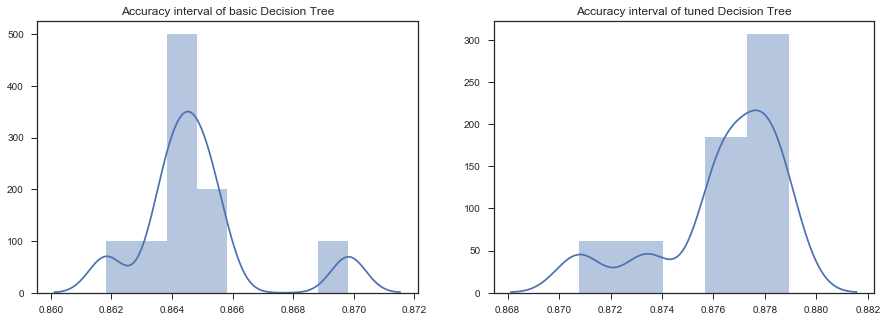

In [39]:
#Model accuracies over multiple iterations
# all_vars = data[['accommodates','reviews','overall_satisfaction','bedrooms','price']].values
# all_rooms = data[['room_type']].values

def mod_accuracy():
    model_accuracies = []
    model_accuracies_tuned = []
    for i in range(10):
        (training_inputs,
         testing_inputs,
         training_classes,
         testing_classes) = train_test_split(all_vars, all_rooms, train_size=0.80)
                            # train_test_split(all_vars, all_rooms, train_size=0.80, random_state=1)

    #   decision_tree_classifier = DecisionTreeClassifier() # Basic DTree classifier
        decision_tree_classifier = tree
        decision_tree_classifier.fit(training_inputs, training_classes)
        classifier_accuracy = decision_tree_classifier.score(testing_inputs, testing_classes)
        model_accuracies.append(classifier_accuracy)
        
        try:
            tree_after_tuning.fit(training_inputs, training_classes) # Tuned Classifier
            classifier_accuracy_tuned = tree_after_tuning.score(testing_inputs, testing_classes)
            model_accuracies_tuned.append(classifier_accuracy_tuned)
        except NameError:
            pass
    return [model_accuracies,model_accuracies_tuned]

f, (left, right) = plt.subplots(1, 2, sharey=False, figsize=(5,6))
f.set_size_inches(15, 5)
p = sb.distplot(mod_accuracy()[0], ax=left)
left.set_title("Accuracy interval of basic Decision Tree")

try:
    p_tuned = sb.distplot(mod_accuracy()[1], ax=right, kde=True)
    right.set_title("Accuracy interval of tuned Decision Tree")
except Exception as e:
    print("NameError encountered. Tune the parameter & rerun this block")

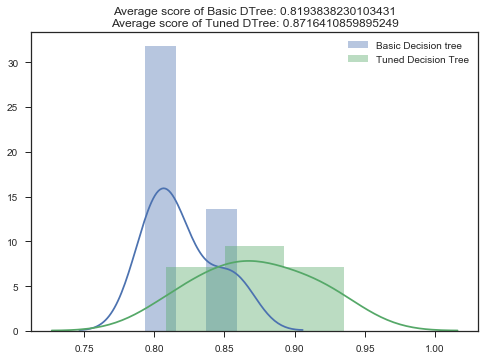

In [40]:
#10-fold cross-validation on decision tree model
#Comparing the performance in both basic and tuned classifier

#k-fold Cross-validation Splits the original data set into k subsets, uses one of the subsets as the testing set, 
#and the rest of the subsets as the training set. 
#This process is repeated k times such that each subset is used as the testing set exactly once.

from sklearn.cross_validation import cross_val_score
decision_tree_classifier = DecisionTreeClassifier()

#shape should be (n,)
all_rooms.shape = (all_rooms.shape[0],)
all_rooms = all_rooms

# We can estimate the performance of classifier by cross_val_score
cv_scores = cross_val_score(decision_tree_classifier, all_vars, all_rooms, cv=10)
sb.distplot(cv_scores)
plt.title('Average score: {}'.format(np.mean(cv_scores)))
plt.legend(["Basic Decision Tree"])

try:
    cv_scores_tuned = cross_val_score(tree_after_tuning, all_vars, all_rooms, cv=10)
    sb.distplot(cv_scores_tuned)
    plt.title('Average score of Basic DTree: {}\nAverage score of Tuned DTree: {}'
              .format(np.mean(cv_scores),np.mean(cv_scores_tuned)))
    plt.legend(['Basic Decision tree','Tuned Decision Tree'])
except NameError:
    pass

## Decision Tree Parameter Tuning

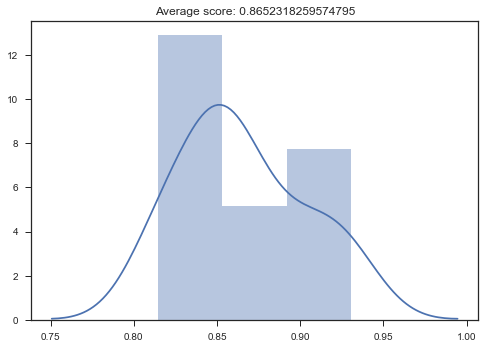

In [31]:
# Parameter tuning of decision tree classifier
# Classifier accuracy changes --> Change depth to see the difference
decision_tree_classifier = DecisionTreeClassifier(max_depth=3)

cv_scores = cross_val_score(decision_tree_classifier, all_vars, all_rooms, cv=10)
sb.distplot(cv_scores, kde=True)
plt.title('Average score: {}'.format(np.mean(cv_scores)))

In [ ]:
#  Discover the best parameters for the model and data set.
#  The most common method for model parameter tuning is Grid Search. 
#      explore a range of parameters and find the best-performing parameter combination. 
#      Focus your search on the best range of parameters, then repeat this process several times until the 
#      best parameters are discovered.
#  Let's tune our decision tree classifier.

In [32]:
# Tuning 2 parameters - max_depth and max_features
# Grid Search is  a common method to tune params 

from sklearn.grid_search import GridSearchCV
from sklearn.cross_validation import StratifiedKFold

tree = DecisionTreeClassifier()

parameter_grid = {'max_depth': [1, 2, 3, 4, 5],
                  'max_features': [1, 2, 3, 4, 5]}

cross_valid = StratifiedKFold(all_rooms, n_folds=10)

grid_search_2p = GridSearchCV(tree, param_grid=parameter_grid, cv=cross_valid)

grid_search_2p.fit(all_vars, all_rooms.ravel())
print('Best score: {}'.format(grid_search_2p.best_score_))
print('Best parameters: {}'.format(grid_search_2p.best_params_))

C:\Users\Niranjan\Anaconda3\lib\site-packages\sklearn\grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


Best score: 0.8741390706273409
Best parameters: {'max_depth': 5, 'max_features': 4}


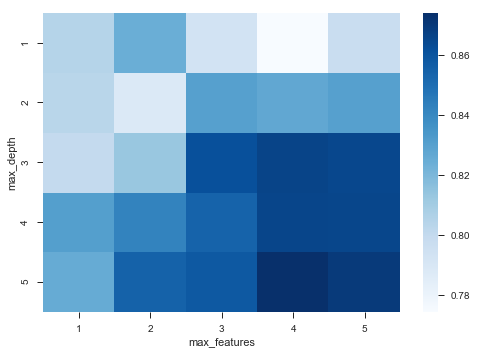

In [33]:
#visualize the grid search to see how the parameters interact.
#Depth >=3 and atleast 4 features will give high accuracy of classifier
grid_visualization = []

for grid_pair in grid_search_2p.grid_scores_:
    grid_visualization.append(grid_pair.mean_validation_score)

grid_visualization = np.array(grid_visualization)
# grid_visualization.shape = (5, 5)
grid_shape = int(math.sqrt(grid_visualization.shape[0]))
grid_visualization.shape = (grid_shape, grid_shape)

sb.heatmap(grid_visualization, cmap='Blues')
plt.xticks(np.arange(5) + 0.5, grid_search_2p.param_grid['max_features'])
plt.yticks(np.arange(5) + 0.5, grid_search_2p.param_grid['max_depth'][::-1])
plt.xlabel('max_features')
plt.ylabel('max_depth')

In [36]:
# Tuning 4 parameters - criterion, splitter, max_depth and max_features

from sklearn.grid_search import GridSearchCV
tree = DecisionTreeClassifier()

#shape should be (n,)
all_rooms.shape = (all_rooms.shape[0],)
all_rooms = all_rooms

parameter_grid = {
    'criterion': ['gini', 'entropy'],
                  'splitter': ['best', 'random'],
                  'max_depth': [1, 2, 3, 4, 5],
                  'max_features': [1, 2, 3, 4, 5]}

cross_valid = StratifiedKFold(all_rooms, n_folds=10)

grid_search_4p = GridSearchCV(tree, param_grid=parameter_grid, cv=cross_valid)

grid_search_4p.fit(all_vars, all_rooms.ravel())
print('Best score: {}'.format(grid_search_4p.best_score_))
print('Best parameters: {}'.format(grid_search_4p.best_params_))

Best score: 0.8716389029915799
Best parameters: {'criterion': 'entropy', 'max_depth': 5, 'max_features': 5, 'splitter': 'best'}


In [37]:
# Taking the best classifier from the Grid Search
tree_after_tuning = grid_search_4p.best_estimator_
tree_after_tuning

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=5,
            max_features=5, max_leaf_nodes=None, min_impurity_split=1e-07,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [41]:
# Making predictions from data in testing_inputs
for input_features, prediction, actual, pred_prob in zip(testing_inputs[:5],
                                              grid_search_4p.predict(testing_inputs[:5]),
                                              testing_classes[:5],
                                              grid_search_4p.predict_proba(testing_inputs[:5])):
    print('{}\t{}\t(Actual:{})\tProb:{}'.format(input_features, prediction, actual, pred_prob))

[  2.    1.    3.5  54.    3. ]	Private room	(Actual:['Private room'])	Prob:[ 0.17410072  0.80543565  0.02046363]
[   2.     1.     4.5   44.   102. ]	Private room	(Actual:['Private room'])	Prob:[ 0.17410072  0.80543565  0.02046363]
[   2.     1.     4.5  162.     4. ]	Entire home/apt	(Actual:['Entire home/apt'])	Prob:[ 0.89797321  0.10099622  0.00103057]
[  3.    1.    4.5  56.    0. ]	Entire home/apt	(Actual:['Entire home/apt'])	Prob:[ 0.77990015  0.21445626  0.00564359]
[   2.     1.     4.5  344.     0. ]	Entire home/apt	(Actual:['Entire home/apt'])	Prob:[ 0.81790372  0.1759781   0.00611818]


In [42]:
# visualize the decision tree with GraphViz 
import sklearn.tree as tree
from sklearn.externals.six import StringIO

with open('airbnb_2016_dtc.dot', 'w') as f:
    f = tree.export_graphviz(tree_after_tuning, out_file=f)

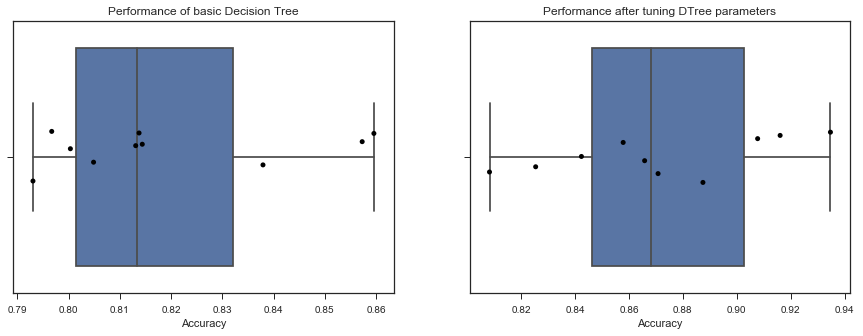

In [43]:
#Compare performance of classifier
dt_scores = cross_val_score(decision_tree_classifier, all_vars, all_rooms, cv=10)
dt_scores_tuned = cross_val_score(tree_after_tuning, all_vars, all_rooms, cv=10)

f, (left, right) = plt.subplots(1, 2, sharey=True, figsize=(5,6))
f.set_size_inches(15, 5)

sb.boxplot(dt_scores, ax=left)
sb.stripplot(dt_scores, jitter=True, color='black', ax=left)

sb.boxplot(dt_scores_tuned, ax=right)
sb.stripplot(dt_scores_tuned, jitter=True, color='black', ax=right)
# sb.despine()

left.set_title("Performance of basic Decision Tree")
left.set_xlabel("Accuracy")
right.set_title("Performance after tuning DTree parameters")
right.set_xlabel("Accuracy")

## Random Forest Classifier
Decision Tree are prone to overfitting, they classify the training set near-perfectly, but fail to generalize to data they have not seen before. Random forest creates a whole bunch of decision trees each trained on random subsets of training samples (drawn with replacement) and features (drawn without replacement) and have the decision trees work together to make a more accurate classification.

In [44]:
# Now tuning parameter for Random Forest classifier 
from sklearn.ensemble import RandomForestClassifier

random_forest_classifier = RandomForestClassifier()

parameter_grid = {'n_estimators': [5, 10, 25, 50],
                  'criterion': ['gini', 'entropy'],
                  'max_features': [1, 2, 3, 4, 5],
                  'warm_start': [True, False]}

cross_validation = StratifiedKFold(all_rooms, n_folds=10)

grid_search_rf = GridSearchCV(random_forest_classifier,
                           param_grid=parameter_grid,
                           cv=cross_validation)

grid_search_rf.fit(all_vars, all_rooms)
print('Best score: {}'.format(grid_search_rf.best_score_))
print('Best parameters: {}'.format(grid_search_rf.best_params_))

grid_search_rf.best_estimator_

Best score: 0.8345961893996724
Best parameters: {'criterion': 'gini', 'max_features': 1, 'n_estimators': 50, 'warm_start': True}


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features=1, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=50, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=True)

In [45]:
# Making predictions from data in testing_inputs
random_forest_classifier = grid_search_rf.best_estimator_
random_forest_classifier.fit(training_inputs, training_classes.ravel())

for input_features, prediction, actual, proba in zip(testing_inputs[:10],
                                              random_forest_classifier.predict(testing_inputs[:10]),
                                              testing_classes[:10],
                                             random_forest_classifier.predict_proba(testing_inputs[:10])):
    print('{}\t\t{}\t(Actual:{})\tProb:{}'.format(input_features, prediction, actual, proba ))

[  2.    1.    3.5  54.    3. ]		Private room	(Actual:['Private room'])	Prob:[ 0.  1.  0.]
[   2.     1.     4.5   44.   102. ]		Private room	(Actual:['Private room'])	Prob:[ 0.29180952  0.70819048  0.        ]
[   2.     1.     4.5  162.     4. ]		Entire home/apt	(Actual:['Entire home/apt'])	Prob:[ 1.  0.  0.]
[  3.    1.    4.5  56.    0. ]		Entire home/apt	(Actual:['Entire home/apt'])	Prob:[ 0.74866667  0.25133333  0.        ]
[   2.     1.     4.5  344.     0. ]		Entire home/apt	(Actual:['Entire home/apt'])	Prob:[ 0.9064127  0.0935873  0.       ]
[  2.    0.    4.5  41.    0. ]		Entire home/apt	(Actual:['Entire home/apt'])	Prob:[ 1.  0.  0.]
[  2.    1.    4.5  52.    0. ]		Private room	(Actual:['Entire home/apt'])	Prob:[ 0.26705116  0.70184299  0.03110586]
[   3.    2.    5.  132.    7.]		Entire home/apt	(Actual:['Entire home/apt'])	Prob:[ 1.  0.  0.]
[   3.    2.    0.  246.    1.]		Entire home/apt	(Actual:['Entire home/apt'])	Prob:[ 1.  0.  0.]
[  2.   1.   0.  90.   2.]		Privat

C:\Users\Niranjan\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:303: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  warn("Warm-start fitting without increasing n_estimators does not "


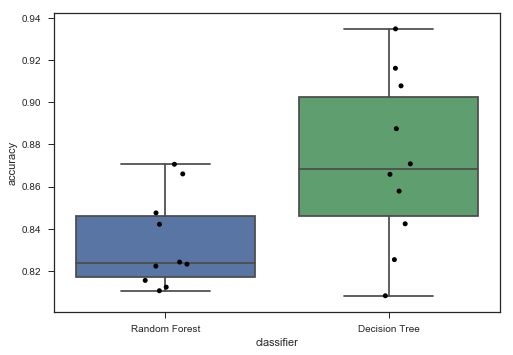

In [46]:
#Compare performance of random forest & decision tree classifier
random_forest_classifier = grid_search_rf.best_estimator_
tree_after_tuning = grid_search_4p.best_estimator_

rf_df = pd.DataFrame({'accuracy': cross_val_score(random_forest_classifier, all_vars, all_rooms, cv=10),
                       'classifier': ['Random Forest'] * 10})
dt_df = pd.DataFrame({'accuracy': cross_val_score(tree_after_tuning, all_vars, all_rooms, cv=10),
                      'classifier': ['Decision Tree'] * 10})
both_df = rf_df.append(dt_df)

sb.boxplot(x='classifier', y='accuracy', data=both_df)
sb.stripplot(x='classifier', y='accuracy', data=both_df, jitter=True, color='black')

## Conclusion
Decision tree classifier seems to be performing better than random forest based on the dataset size and number of features used to make the prediction. Random forest is recommended when there are many features in the dataset that can be used to build a predictive model.